<a href="https://colab.research.google.com/github/shavi-dil/Team-3/blob/main/LSTM_TRAFFIC_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [3]:
# Load your CSV
df = pd.read_csv('/content/Traffic_Count_Locations_with_LONG_LAT.csv')

# Display basic info
print("Columns:", df.columns)
df[['YEAR_SINCE', 'AADT_ALLVE']].head()


Columns: Index(['X', 'Y', 'FID', 'OBJECTID', 'TFM_ID', 'TFM_DESC', 'TFM_TYP_DE',
       'MOVEMENT_T', 'SITE_DESC', 'ROAD_NBR', 'DECLARED_R', 'LOCAL_ROAD',
       'DATA_SRC_C', 'DATA_SOURC', 'TIME_CATEG', 'YEAR_SINCE', 'LAST_YEAR',
       'AADT_ALLVE', 'AADT_TRUCK', 'PER_TRUCKS'],
      dtype='object')


,YEAR_SINCE,AADT_ALLVE
0,19,7700
1,16,1900
2,23,15000
3,19,12000
4,19,12000


In [4]:
# Drop rows with missing values in key columns
df = df[['YEAR_SINCE', 'AADT_ALLVE']].dropna()

# Sort by year (important for time series)
df = df.sort_values(by='YEAR_SINCE')

# Reset index
df.reset_index(drop=True, inplace=True)


In [5]:
# Normalize AADT_ALLVE only
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['AADT_ALLVE']])

# Create sequences for LSTM (e.g., look back 5 years)
def create_sequences(data, look_back=5):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 5
X, y = create_sequences(data_scaled, look_back)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (57942, 5, 1)
y shape: (57942, 1)


In [6]:
# Split into train and test sets (e.g., 80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2898/2898 ━━━━━━━━━━━━━━━━━━━━ 17s 5ms/step - loss: 0.0046 - val_loss: 0.0094
Epoch 2/20
2898/2898 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0044 - val_loss: 0.0082
Epoch 3/20
2898/2898 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.0044 - val_loss: 0.0086
Epoch 4/20
2898/2898 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0041 - val_loss: 0.0087
Epoch 5/20
2898/2898 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0041 - val_loss: 0.0084
Epoch 6/20
2898/2898 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0041 - val_loss: 0.0081
Epoch 7/20
2898/2898 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - loss: 0.0041 - val_loss: 0.0084
Epoch 8/20
2898/2898 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - loss: 0.0041 - val_loss: 0.0086
Epoch 9/20
2898/2898 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - loss: 0.0040 - val_loss: 0.0084
Epoch 10/20
2898/2898 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0044 - val_loss: 0.0084
Epoch 11/20
2898/2898 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.0043 - val_loss: 0.0083
Epoch 12/20
2898/2898 ━━━━━━━━

363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


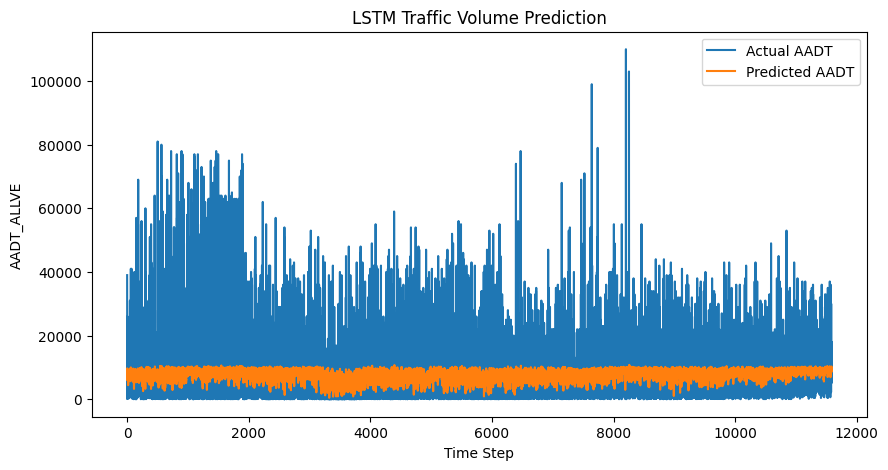

In [7]:
# Predict on test data
predicted = model.predict(X_test)

# Inverse transform to original scale
predicted_actual = scaler.inverse_transform(predicted)
y_actual = scaler.inverse_transform(y_test)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_actual, label='Actual AADT')
plt.plot(predicted_actual, label='Predicted AADT')
plt.legend()
plt.title('LSTM Traffic Volume Prediction')
plt.xlabel('Time Step')
plt.ylabel('AADT_ALLVE')
plt.show()
